In [1]:
import json, pathlib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score

In [2]:
# Load data
#seeds = [3011, 3012, 3013, 3014, 3015, 3031, 3032, 3033, 3034, 3035]
seeds = [3021, 3022, 3023, 3024, 3025, 3041, 3042, 3043, 3044, 3045]

predictions = []
for seed in seeds:
    filepath = pathlib.Path(f"results/wavlm_large_ecapa_tdnn/seed_{seed}/predictions.json")
    with open(filepath) as f:
        predictions.extend([
            {"pid": k, "seed": seed, "label": v["label"], "score": v["score"], "sex": v["sex"]}
            for k, v in json.load(f).items()
        ])

df = pd.DataFrame.from_records(predictions)

df

,pid,seed,label,score,sex
0,PD00106,3021,1,0.551,F
1,CTL0007_24012025,3021,0,0.238,M
2,PD01022,3021,1,0.558,F
3,CTL0014_04032025,3021,0,0.248,F
4,MNI0452,3021,1,0.566,M
...,...,...,...,...,...
995,MNI0545,3045,0,0.495,M
996,MNI0414,3045,0,0.725,M
997,MNI0336,3045,1,0.500,M
998,MNI0448,3045,1,0.492,M


In [3]:
def auc_difference(data, verbose=False):
    """AUC difference (Female minus Male)."""
    subset_m = data[data.sex == "M"]
    subset_f = data[data.sex == "F"]

    score_m = roc_auc_score(subset_m.label, subset_m.score)
    score_f = roc_auc_score(subset_f.label, subset_f.score)

    if verbose:
        print(f"Male AUC:   {score_m:.1%}")
        print(f"Female AUC: {score_f:.1%}")

    return score_f - score_m

def f1_difference(data, verbose=False):
    """F1 difference (Female minus Male)."""
    subset_m = data[data.sex == "M"]
    subset_f = data[data.sex == "F"]

    score_m = f1_score(subset_m.label, subset_m.score >= 0.5)
    score_f = f1_score(subset_f.label, subset_f.score >= 0.5)

    if verbose:
        print(f"Male F1:   {score_m:.1%}")
        print(f"Female F1: {score_f:.1%}")

    return score_f - score_m

def male_female_subject_permutation_test(df, n_permutations=2000, seed=42, test_metric=auc_difference):
    """
    Stratified permutation test for male vs female score difference
    Keeps disease status balance (shuffles sex only within each label group).

    Tests whether the difference in score between males and females is likely
    to be due to broad sex differences or is rather due to individual differences (null).

    df must contain: pid, label, score, sex, seed
    - sex: 'M' or 'F'
    - label: ground-truth label (0/1)
    - score: predicted score (continuous)
    """
    rng = np.random.default_rng(seed)
    df = df.copy()

    # Observed difference
    observed_score = test_metric(df, verbose=True)

    # Build permutation null
    null_scores = []
    unique_pids = df[["pid", "label", "sex"]].drop_duplicates()

    # Copy once to avoid slowdown to excessive copies
    permuted = unique_pids.copy()

    for _ in range(n_permutations):
        # Stratify by disease status
        for label in unique_pids.label.unique():
            mask = permuted.label == label
            permuted.loc[mask, "sex"] = rng.permutation(permuted.loc[mask, "sex"].values)

        # Map back shuffled sexes
        pid2sex = dict(zip(permuted.pid, permuted.sex))
        df.sex = df.pid.map(pid2sex)

        null_scores.append(test_metric(df))

    null_scores = np.array(null_scores)

    # One-sided p-value: prob(null >= observed)
    p_value = np.mean(null_scores >= observed_score)

    return observed_score, p_value, null_scores

In [4]:
observed_score, p_value, null_scores = male_female_subject_permutation_test(df, test_metric=auc_difference)
print(f"Observed Female AUC - Male AUC: {observed_score:.1%}")
print(f"Permutation p-value: {p_value:.2f}")

Male AUC:   63.6%
Female AUC: 69.4%
Observed Female AUC - Male AUC: 5.8%
Permutation p-value: 0.28


In [5]:
observed_score, p_value, null_scores = male_female_subject_permutation_test(df, test_metric=f1_difference)
print(f"Observed Female F1 - Male F1: {observed_score:.1%}")
print(f"Permutation p-value: {p_value:.2f}")

Male F1:   58.3%
Female F1: 65.2%
Observed Female F1 - Male F1: 6.9%
Permutation p-value: 0.20


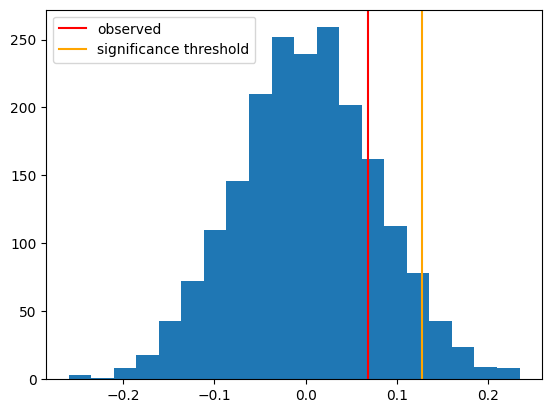

In [6]:
plt.hist(null_scores, bins=20)
plt.axvline(observed_score, color="red")
plt.axvline(np.quantile(null_scores, 0.95), color="orange")
plt.legend(["observed", "significance threshold"])
plt.show()

In [7]:
def male_female_seed_permutation_test(df, n_permutations=2000, seed=42, test_metric=auc_difference):
    """
    Permutation test for male vs female score difference, computed by swapping ALL males/females
    from a single seed, rather than individuals. This ignores the high individual variability,
    instead measuring whether, for our data, the women perform better than the men regardless of seed.
    This is a non-parametric version of a t-test 

    df must contain: pid, label, score, sex, seed
    - sex: 'M' or 'F'
    - label: ground-truth label (0/1)
    - score: predicted score (continuous)
    """
    rng = np.random.default_rng(seed)
    df = df.copy()

    # Observed differences
    trials = []
    for s in seeds:
        trials.append(test_metric(df[(df.seed == s)]))

    observed_score = np.mean(trials)

    # Build permutation null
    null_scores = []
    trials = np.array(trials)
    for _ in range(n_permutations):
        # Shuffle labels by randomly changing the sign
        sign = rng.integers(2, size=10) * 2 - 1
        null_scores.append(np.mean(sign * trials))

    # One-sided p-value: prob(null >= observed)
    null_scores = np.array(null_scores)
    p_value = np.mean(null_scores >= observed_score)

    return observed_score, p_value, null_scores

In [16]:
observed_score, p_value, null_scores = male_female_seed_permutation_test(df, test_metric=auc_difference)
print(f"Observed Female AUC - Male AUC: {observed_score:.1%}")
print(f"Permutation p-value: {p_value:.2g}")

Observed Female AUC - Male AUC: 5.7%
Permutation p-value: 0.0035


In [17]:
observed_score, p_value, null_scores = male_female_seed_permutation_test(df, test_metric=f1_difference)
print(f"Observed Female F1 - Male F1: {observed_score:.1%}")
print(f"Permutation p-value: {p_value:.2g}")

Observed Female F1 - Male F1: 6.8%
Permutation p-value: 0.0045


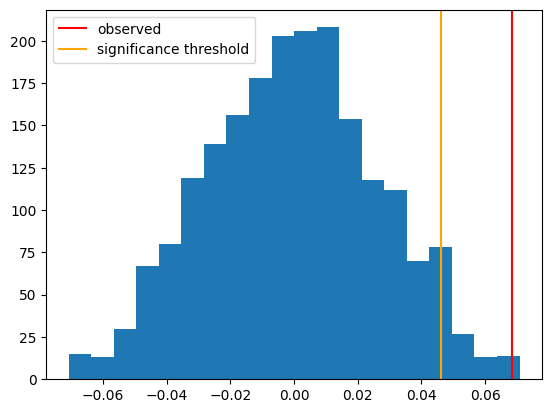

In [9]:
plt.hist(null_scores, bins=20)
plt.axvline(observed_score, color="red")
plt.axvline(np.quantile(null_scores, 0.95), color="orange")
plt.legend(["observed", "significance threshold"])
plt.show()

In [10]:
def auc(df):
    return roc_auc_score(df.label, df.score)

def f1(df):
    return f1_score(df.label, df.score >= 0.5)

def permutation_test(df, n_permutations=2000, seed=42, test_metric=auc):
    """
    Permutation test to determine if scores are above chance.

    df must contain: pid, label, score, sex, seed
    - sex: 'M' or 'F'
    - label: ground-truth label (0/1)
    - score: predicted score (continuous)
    """
    rng = np.random.default_rng(seed)
    df = df.copy()

    # Observed score
    observed_score = test_metric(df)

    # Build permutation null
    null_scores = []
    pids = df.pid.unique()
    labels = df[df.seed == seeds[0]].label
    for _ in range(n_permutations):
        labels = rng.permutation(labels)
        pid2label = dict(zip(pids, labels))
        df.label = df.pid.map(pid2label)
        null_scores.append(test_metric(df))

    # One-sided p-value: prob(null >= observed)
    null_scores = np.array(null_scores)
    p_value = np.mean(null_scores >= observed_score)

    return observed_score, p_value, null_scores

In [13]:
observed_score, p_value, null_distribution = permutation_test(df[df.sex == "F"], test_metric=f1)
print(f"Observed F1: {observed_score:.1%}")
print(f"Mean null F1: {null_distribution.mean():.1%}")
print(f"P-value: {p_value}")

Observed F1: 65.2%
Mean null F1: 54.3%
P-value: 0.0215


In [14]:
observed_score, p_value, null_distribution = permutation_test(df[df.sex == "F"], test_metric=auc)
print(f"Observed AUC: {observed_score:.1%}")
print(f"Mean null AUC: {null_distribution.mean():.1%}")
print(f"P-value: {p_value}")

Observed AUC: 69.4%
Mean null AUC: 50.1%
P-value: 0.003


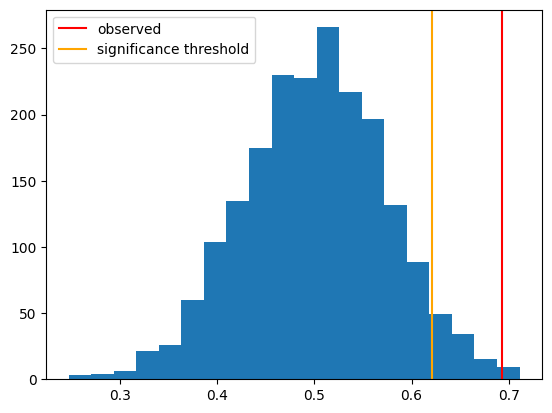

In [15]:
plt.hist(null_distribution, bins=20)
plt.axvline(observed_score, color="red")
plt.axvline(np.quantile(null_distribution, 0.95), color="orange")
plt.legend(["observed", "significance threshold"])
plt.show()